**Gate Detection With PyTorch**

In this notebook, we use PyTorch's pretrained models to detect the start gate and start tick of the underwater obstacle course. 

See [docs](https://pytorch.org/docs/stable/torchvision/models.html) for a very helpful general overview of torchvision.models. I used [this](https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101) and [this link](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to figure out how to read in the image/label data. I followed [this tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and [this link](https://github.com/pytorch/vision/blob/master/references/detection/engine.py) for retraining and fine-tuning a pretrained model.

To get a general understanding of how convolutional neural networks work, I'd recommend [this tutorial](http://cs231n.github.io/convolutional-networks/). To learn the basics of PyTorch, I'd first read up on [Autograd](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95), the core of PyTorch's functionality, and then carefully follow [this tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html).

If you're running this notebook for the first time, do a CTRL+F for "ATTENTION" to see which parts of the notebook you'll need to modify to fit your Drive. I left a lot of comments throughout the notebook to try to explain what everything does and how everything works. 

In [0]:
# Import some packages
import torch
import torchvision
from torchvision import models, transforms, datasets
from skimage import io, transform
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
# ATTENTION: Connect the notebook to your Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


To get the notebook to work, you should create a folder containing four items: one folder each for the training frames, test frames, training labels, and test labels. 

In [0]:
import os
os.chdir('/content/drive/My Drive/Duke/Robotics/Gate Data') # ATTENTION: Change to your location

# ATTENTION: modify the constants below to match your Drive

# Folder paths/names for your train/test image files and XML labels
TRAIN_FRAMES = 'approach1_frames_train'
TRAIN_LABELS = 'approach1_labels_train'
TEST_FRAMES = 'approach1_frames_test'
TEST_LABELS = 'approach1_labels_test'

# Names/location of the CSV label files that will be generated later on
TRAIN_CSV = 'labels_train.csv'
TEST_CSV = 'labels_test.csv'

# Video input path and where you want the generated output videos to be stored
# Find videos here: https://drive.google.com/drive/u/0/folders/1bLXE65Dwq0K95ePldaUOyT9JdhaMq1XR
VIDEO_1 = 'videos/approach1.mp4'
VIDEO_1_OUTPUT = 'videos_gen/approach1.avi'
VIDEO_2 = 'videos/approach2.mp4'
VIDEO_2_OUTPUT = 'videos_gen/approach2.avi'

In [7]:
# Check that you're in the right directory
!ls

approach1_frames_test	approach1_labels_train	test_image.png
approach1_frames_train	labels_test.csv		videos
approach1_labels_test	labels_train.csv	videos_gen


(1080, 1720, 3)


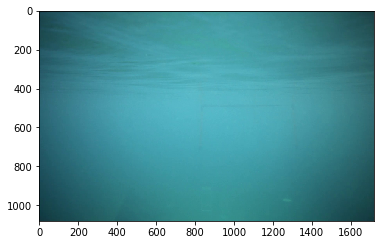

In [8]:
# Read in one image to confirm the data is good
img_name = os.path.join(TEST_FRAMES, 'frame0.jpg')
image = io.imread(img_name)
print(image.shape)
plt.imshow(image)

In [9]:
# Apply some preliminary transformations to the image we read in
transform_img = transforms.Compose([
                transforms.ToPILImage(),
                # Random flipping helps with data augmentation, but the problem
                # is that it would mess up our labels for half of the dataset,
                # so for now we'll turn it off
                # transforms.RandomHorizontalFlip(), # randomly flip some images for better train data
                transforms.ToTensor(), 
                transforms.Normalize(mean=[0.485, 0.456, 0.406], # default for pretrained models
                                    std=[0.229, 0.224, 0.225]),
            ])

img = transform_img(image)
# Shape should be (3, height, width), where 3 is the number of colors in RGB
# This shape is necessary for when we eventually feed it into the pretrained models
img.shape

torch.Size([3, 1080, 1720])

Now that we have the data ready and were able to pull up an image, let's actually read in the data and clean it to be ready to feed into a model. 

In [10]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET

# Convert all the XML files into a single CSV file
# Source: https://github.com/datitran/raccoon_dataset/blob/master/xml_to_csv.py
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            filename = root.find('filename').text
            # Images are in the format frame##.jpg
            # The XML data is formatted differently for images ## in the range [0, 200)
            # This code sets the correct index based on ## from the filename
            pos_index = 5 if int(filename[5:filename.index('.')]) < 200 else 4
            
            value = (filename,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[pos_index][0].text),
                     int(member[pos_index][1].text),
                     int(member[pos_index][2].text),
                     int(member[pos_index][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
  
# ATTENTION: Uncomment the lines below to generate the CSV files if you 
# haven't already. You only need to do this step once. 
"""xml_df = xml_to_csv(TRAIN_LABELS)
xml_df.to_csv(TRAIN_CSV, index=None)
xml_df = xml_to_csv(TEST_LABELS)
xml_df.to_csv(TEST_CSV, index=None)"""

'xml_df = xml_to_csv(TRAIN_LABELS)\nxml_df.to_csv(TRAIN_CSV, index=None)\nxml_df = xml_to_csv(TEST_LABELS)\nxml_df.to_csv(TEST_CSV, index=None)'

In [0]:
# Map string labels to ints to feed into model
# Important: the background, or default, label should be 0, as that is how the
# models were pretrained. The model wasn't predicting any start_gates when I 
# had its label as 0 instead of 1!
def label_to_int(label):
    if label == 'start_gate':
        return 1
    if label == 'start_tick':
        return 2
    return 0

# Map ints from model predictions to string labels
def int_to_label(val):
    if val == 1:
        return 'start_gate'
    if val == 2:
        return 'start_tick'
    return 'background'

In [0]:
# To train a model, we need not only a list of tensors for the image input data,
# but also targets, a list of dictionaries, each dict containing the following: 
# - boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] 
#     format, with values between 0 and H and 0 and W
# - labels (Int64Tensor[N]): the class label for each ground-truth box
# 
# Note: N is however many objects you've chosen to label in the current image.
# In our situation, we separate multiple objects in an image into multiple test
# cases, so N is always just 1. 
# 
# For example, we can pass the following two lists into the model for training:
# 1. [list of tensors with shape (3, height, width)] 
# 2. [list of dicts containing the keys "boxes" and "labels"]
# 
# Given we have a lot of big images, we don't want to read in all the images
# at once. Instead, let's create a Dataset class that initially loads just 
# the CSV file and loads the images one-by-one when they're specificially 
# indexed for. 
#
# Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

class GateDataset(torch.utils.data.Dataset):

    # csv_file: Path to the csv file with annotations.
    # root_dir: Path to the directory with all the images.
    # transform: Optional transform to be applied on a sample.
    def __init__(self, csv_file, root_dir, transform=None):
        # CSV file contains: filename, width, height, class, xmin, ymin, xmax, ymax
        self.csv = pd.read_csv(csv_file)

        self.root_dir = root_dir
        self.transform = transform

    # Returns the length of this dataset
    def __len__(self):
        return len(self.csv)

    # Is what allows you to index the dataset, e.g. dataset[0]
    # dataset[index] returns a tuple containin the image and the targets list
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read in the image from the file name in the 0th column
        img_name = os.path.join(self.root_dir, self.csv.iloc[idx, 0])
        image = io.imread(img_name)

        # Read in xmin, ymin, xmax, and ymax 
        box = self.csv.iloc[idx, 4:]
        box = torch.tensor(box).view(1, 4)

        # Read in the label: start_tick or start_gate
        label = self.csv.iloc[idx, 3]
        label = torch.tensor(label_to_int(label)).view(1)

        targets = {'boxes': box, 'labels': label}
        # Perform transformations such as normalization if provided
        if self.transform:
            image = self.transform(image)

        """
        TODO: right now, the resizing step is done in a separate transform
        step, which means that we also have to separate the step when using the 
        model to make predictions. In the future, shift the resizing responsibility
        to the user of this class, and allow them to pass in an argument specifying
        how much they scaled the image down by so we can then scale down the boxes.
        """
        height = self.csv.loc[0, 'height']
        # Decrease size of images by 10x to increase training speeds
        resize = transforms.Resize(int(height / 10))
        # Before resizing, image needs to be a PILImage if it's not already 
        if not isinstance(image, PIL.Image.Image):
            image = transforms.ToPILImage()(image)
        image = resize(image)
        # Convert image back into a tensor
        image = transforms.ToTensor()(image)

        # Simiarly, divide each boundary of box by 10 to match the resized image
        box /= 10

        return image, targets

In [13]:
dataset = GateDataset(TEST_CSV, TEST_FRAMES, transform=None)
image, target = dataset[0]
# Shows image shape, bounds of the box, and the label for the item in the box
image.shape, target['boxes'], target['labels']

(torch.Size([3, 108, 172]), tensor([[111,  46, 115,  62]]), tensor([2]))

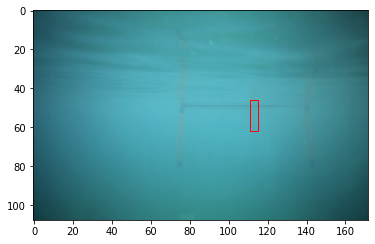

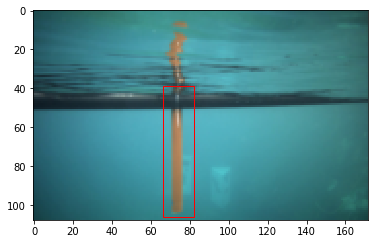

In [14]:
# Show the image along with the specified boxes around the labeled item
def show_labeled_image(image, boxes):    
    fig, ax = plt.subplots(1)
    # If the image is already a tensor, convert it back to a PILImage
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)
    ax.imshow(image)

    # Show a single box or multiple if provided
    if boxes.ndim == 1:
        boxes = [boxes]
    for box in boxes:
        width, height = box[2] - box[0], box[3] - box[1]
        initial_pos = (box[0], box[1])
        rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                edgecolor='r', facecolor='none')

        ax.add_patch(rect)
    plt.show()

image, target = dataset[0]
show_labeled_image(image, target['boxes'][0])

image, target = dataset[10]
show_labeled_image(image, target['boxes'][0])

Now that we have a working Dataset class, we can begin feeding the data into an actual model. We'll be using one of PyTorch's pretrained models, but fine-tuning it with our data. 

In [15]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Number of classes we want the fine-tuned model to predict
num_classes = 3  # start_tick + start_gate + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 61.7MB/s]


In [0]:
# Run the model on GPU if it's available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [0]:
# In the next code block, we use data loaders to feed our data into the model in 
# batches. This function takes in a list of the tuples returned by our custom 
# dataset (GateDataset) and we can specify how the data should be batched. In
# our case, we want to return a tuple containing the images list and targets list.
def collate_data(batch):
    # Converts a list of tuples into a tuple of lists
    images, targets = zip(*batch)
    return list(images), list(targets)

In [0]:
# Create the train and test datasets
dataset_train = GateDataset(TRAIN_CSV, TRAIN_FRAMES, transform=transform_img)
dataset_test = GateDataset(TEST_CSV, TEST_FRAMES, transform=transform_img)

# Create data loaders for the datasets to feed them in batches to the model
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_data)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_data)

In [0]:
# Helper function to send all the images and tensors within targets to the GPU, if available
def to_device(images, targets, device):
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets

In [0]:
# The function we will use to actually train the model
def train_model(model, data_loader, device, epochs=10, learning_rate=0.001):
    # Set model to be in train mode (some models' internal behavior depends on it)
    model.train()

    losses = []
    # Get parameters that have grad turned on (i.e. parameters that should be trained)
    parameters = [p for p in model.parameters() if p.requires_grad]
    # Create an optimizer that uses SGD (stochastic gradient descent) to train the parameters
    optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=0.9)
    
    # Train on the entire dataset for the specified number of times (epochs)
    for epoch in range(epochs):
        for images, targets in data_loader:
            images, targets = to_device(images, targets, device)

            # Calculate the model's loss (i.e. how well it does on the current 
            # image and target, with a lower loss being better)
            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())

            # Zero any old/existing gradients on the model's parameters
            optimizer.zero_grad()
            # Compute gradients for each parameter based on the current loss calculation
            total_loss.backward()
            # Update model parameters from gradients: param -= learning_rate * param.grad
            optimizer.step()
            # Keep track of the loss (converted from a tensor to a normal number
            # to save space on the GPU)
            losses.append(total_loss.item())

    return losses

In [0]:
# Train the model - this step takes a while, so make sure you have the GPU turned on
# ATTENTION: Go to Edit -> Notebook Settings -> Hardware accelerator -> GPU
# If you didn't do this before, rerun the cells starting from where you initialized device
losses = train_model(model, loader_train, device, epochs=1)

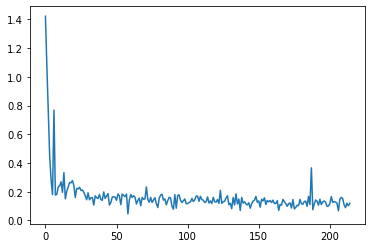

In [22]:
# Visualize loss of the model over time; it should be decreasing
plt.plot(losses)
plt.show()

In [23]:
# Takes in image(s) and makes predictions
def get_predictions(model, image, device):
    # Set model mode to eval now that we're done with training
    model.eval()

    # Since we're done training and just evaluating, we can save memory and speed
    # by disabling gradients, which we only needed during training
    with torch.no_grad():
        # Once again, send images to the GPU if it's available
        if isinstance(image, list):
            images = [img.to(device) for img in image]
        else:
            # Convert image into a list of length 1 if not already a list
            images = [image.to(device)]
        preds = model(images)
        # Send predictions to CPU to save space on GPU
        preds = [{k: v.to(torch.device('cpu')) for k, v in p.items()} for p in preds]
        return preds

predictions = get_predictions(model, dataset_test[20][0], device)
# If we passed in a list of N images, predictions is a list of N dictionaries,
# each containing the keys boxes, labels, and scores
predictions

[{'boxes': tensor([[  0.0000,  38.0510, 167.4387, 104.6895],
          [ 86.9547,  38.1831,  94.4757,  80.3477],
          [ 56.1170,  47.0169, 153.5192, 101.9697],
          [ 85.8179,  48.2088, 141.0288,  79.7358],
          [ 88.9532,  37.9855, 150.8050,  92.5985],
          [149.0014,   0.0000, 172.0000, 108.0000],
          [ 84.5067,  29.3193,  96.2649,  91.4902],
          [147.8919,  25.1247, 162.7078, 107.7570],
          [ 88.2169,  41.9171,  93.1870,  70.8745],
          [148.0273,  20.6444, 162.9873, 108.0000],
          [ 86.4784,  46.1272,  94.8324,  81.5932],
          [149.3347,   1.4125, 172.0000, 108.0000],
          [ 69.5382,  11.0647, 172.0000, 104.8540],
          [ 35.2752,  53.4421,  91.6400,  81.5652],
          [ 41.8172,  51.4168, 134.7670,  87.2298],
          [  0.0000,  75.0685, 160.3436, 104.8467],
          [ 21.8411,  47.3764,  99.5185,  95.6569],
          [154.6272,  40.6094, 171.5391, 103.9422],
          [148.0376,  36.3017, 171.6324,  78.3551],
   

In [24]:
# Create a helper function that returns predictions in an easier-to-use format
# Returns a list of lists of four values: a list of labels, list of boxes, 
# list of scores, and the image
def get_clean_predictions(model, image, device):
    preds = get_predictions(model, image, device)

    results = []
    for pred in preds:
        result = [[int_to_label(val) for val in pred['labels']], pred['boxes'], pred['scores']]
        result.append(image)
        results.append(result)
    return results

# For dataset[10], get the predicted labels/boxes/scores as well as the image itself
labels, boxes, scores, image = get_clean_predictions(model, dataset_test[10][0], device)[0]
print('Predicted {} with a score of {} within the following box: {}'.format(labels[0], scores[0], boxes[0]))
labels, boxes, scores, image.shape

Predicted start_gate with a score of 0.6435708999633789 within the following box: tensor([  3.6929,  28.2013, 172.0000, 108.0000])


(['start_gate',
  'start_gate',
  'start_gate',
  'start_tick',
  'start_gate',
  'start_gate',
  'start_tick',
  'start_gate',
  'start_tick',
  'start_gate',
  'start_gate',
  'start_gate',
  'start_gate',
  'start_gate',
  'start_tick',
  'start_gate',
  'start_tick'],
 tensor([[  3.6929,  28.2013, 172.0000, 108.0000],
         [ 58.2188,  53.5117, 170.0926,  91.3959],
         [  7.1489,  50.1102,  97.2085, 106.8479],
         [ 68.0149,  48.8834,  78.2293, 101.6132],
         [ 43.5073,  48.6355, 143.1636, 103.7087],
         [  8.9783,  56.9372,  77.0109,  92.7163],
         [ 69.5483,  40.5089,  83.7374, 106.7732],
         [ 67.7958,  57.3263,  82.5481, 104.6914],
         [ 69.1365,  42.2288,  74.1641, 103.4870],
         [  0.0000,  72.7891, 151.8308, 103.7742],
         [ 83.7195,  35.4403, 166.7209, 108.0000],
         [ 69.3215,  48.5287,  76.0128, 104.7060],
         [ 51.2947,  53.0523,  91.5965, 101.8003],
         [ 70.4045,  46.4794,  88.5120, 106.5340],
         [ 74

['start_gate', 'start_gate', 'start_gate', 'start_gate', 'start_gate']


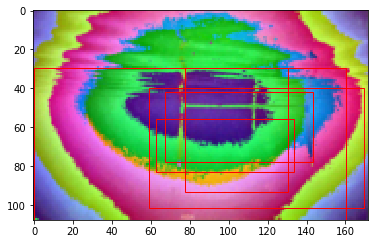

In [25]:
# Plot the top few boxes predicted 
labels, boxes, scores, image = get_clean_predictions(model, dataset_test[0][0], device)[0]
print(labels[:5])
show_labeled_image(image, boxes[:5])
# Note: the images are colored weirdly likely because we applied the normalize
# transformation when loading the images into the GateDataset

In [0]:
# Takes in the lists of labels/boxes/scores and filters out the top prediction
# of each class (start_gate and start_tick). Returns a list of size num_classes
# with each element being a tuple (label, box, score)
def filter_top_predictions(labels, boxes, scores):
    preds = []
    # Loop through each unique label
    for label in set(labels):
        # Get first index of label, which is also its highest scoring occurrence
        index = labels.index(label)
        preds.append((label, boxes[index], scores[index]))
    return preds

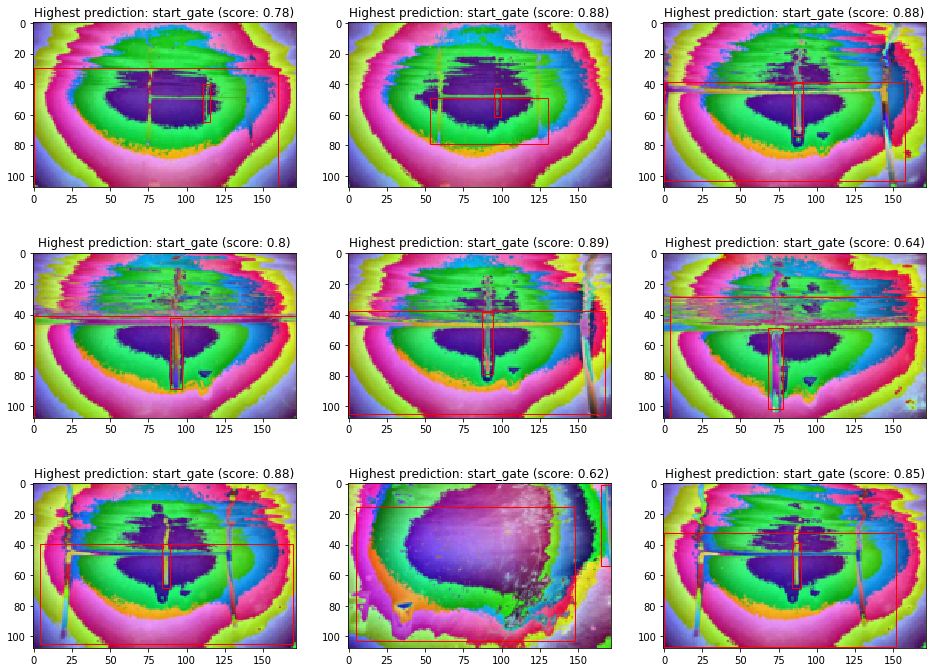

In [27]:
# Plot 9 predictions at once showing the boxes for the top predictions of each class
def plot_prediction_grid(model, dataset, start=0, step=2):
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))

    index = start
    for i in range(3):
        for j in range(3):
            # Get the predictions and plot the box with the highest score
            labels, boxes, scores, image = get_clean_predictions(model, dataset[index][0], device)[0]
            index += step # Jump ahead step elements in the dataset

            image = transforms.ToPILImage()(image)
            axes[i, j].imshow(image)

            for _, box, _ in filter_top_predictions(labels, boxes, scores):
                width, height = box[2] - box[0], box[3] - box[1]
                initial_pos = (box[0], box[1])
                rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                            edgecolor='r', facecolor='none')
                axes[i, j].add_patch(rect)
            axes[i, j].set_title('Highest prediction: {} (score: {})'.format(labels[0], round(scores[0].item(), 2)))

    plt.show()

plot_prediction_grid(model, dataset_test)

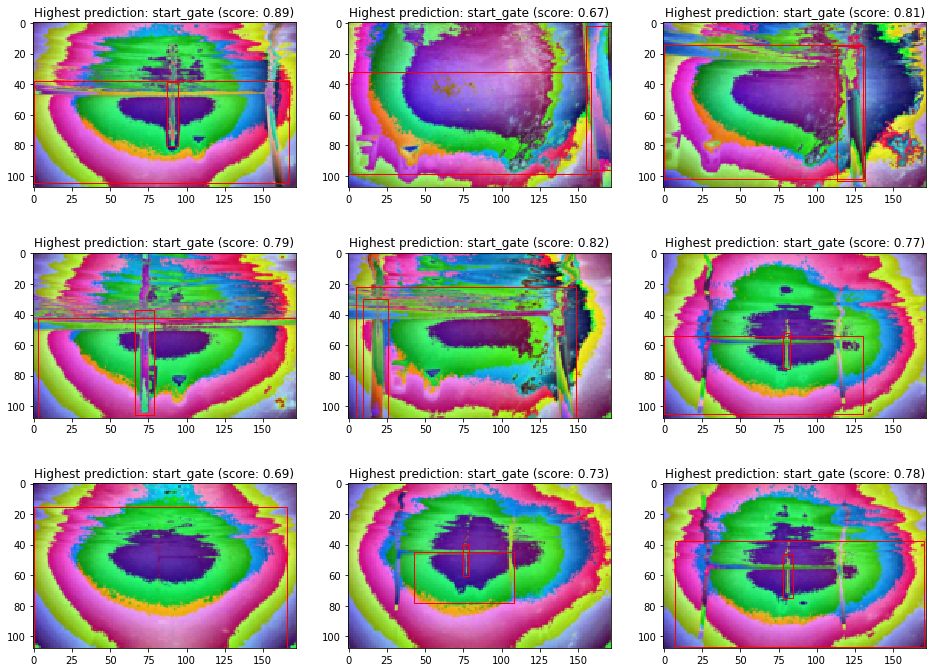

In [28]:
plot_prediction_grid(model, dataset_test, 20, 3)

Now, let's try running it on a video. I used [this tutorial](https://www.pyimagesearch.com/2017/09/18/real-time-object-detection-with-deep-learning-and-opencv/) to learn how to write boxes and text onto frames and [this post](https://stackoverflow.com/a/29317298/7386515) to figure out how to write to a video file. 

In [0]:
import cv2

# Runs the model predictions on the given video file and produces an output
# video with real-time boxes and labels around detected objects
def detect_video(model, device, input_file, output_file):
    # Read in the video
    video = cv2.VideoCapture(input_file)

    # Video frame dimensions
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # How much we scale down the frames when feeding them into the model
    scale_down_factor = 10

    # The VideoWriter with which we'll write our video with the boxes and labels
    # Parameters: filename, fourcc, fps, frame_size
    out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'DIVX'), 20.0, (frame_width, frame_height))

    # Transform to apply on individual frames of the video
    transform_frame = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.ToPILImage(),
        transforms.Resize(int(frame_height / scale_down_factor)),
        transforms.ToTensor(),
        # Because of bad initial design, I have it so you need to turn it to a
        # tensor, then normalize, then resize as a PILImage, then convert back
        # to a tensor again for the model to predict good results. It will
        # take a little refactoring later on to improve this process.
    ])

    # Loop through every frame of the video
    while True:
        ret, frame = video.read()
        # Stop the loop when we're done with the video
        if not ret:
            break

        # The transformed frame is what we'll feed into our model
        transformed_frame = transform_frame(frame)

        # Get our model predictions
        labels, boxes, scores, _ = get_clean_predictions(model, transformed_frame, device)[0]
        
        # Add the top prediction of each class to the frame
        for label, box, score in filter_top_predictions(labels, boxes, scores):
            # Since the predictions are for scaled down frames, we need to increase the box dimensions
            box *= scale_down_factor

            # Create the box around each object detected
            # Parameters: frame, (start_x, start_y), (end_x, end_y), (r, g, b), thickness
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

            # Write the label and score for the boxes
            # Parameters: frame, text, (start_x, start_y), font, font scale, (r, g, b), thickness
            cv2.putText(frame, '{}: {}'.format(label, round(score.item(), 2)), (box[0], box[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Write this frame to our video file
        out.write(frame)

        # If the 'q' key is pressed, break from the loop
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    # When finished, release the video capture and writer objects
    video.release()
    out.release()
    
    # Closes all the frames
    cv2.destroyAllWindows()

# Now you can see the video with boxes at the path VIDEO_1_OUTPUT
# Note: this step can also take awhile
detect_video(model, device, VIDEO_1, VIDEO_1_OUTPUT)